In [1]:
import numpy as np
import math
import operator
import networkx as nx
from itertools import permutations
import matplotlib.pyplot as plt
from deap import creator, base, tools, algorithms,gp
import dimod
import dwave_networkx as dnx
import import_ipynb
import tsp_parser
from tsp_parser import read_tsp_file
from operator import itemgetter

importing Jupyter notebook from tsp_parser.ipynb
importing Jupyter notebook from city.ipynb


In [2]:
tsp = read_tsp_file('./symmetric_problems/berlin52.tsp')

In [3]:
len(tsp['CITIES'])

52

In [4]:
def plotGraph(G,show_weights=False):
    pos=nx.get_node_attributes(G,'coord')
    nx.draw(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    if show_weights:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

In [5]:
def distance(A, B): 
    "The Euclidean distance between two cities."
    return math.sqrt( ((A[0]-B[0])**2)+((A[1]-B[1])**2) )

In [6]:
def total_distance(G):
    total =0
    for edge in G.edges: 
        total += distance(G.nodes[edge[0]]["pos"],G.nodes[edge[1]]["pos"])
    return total

In [7]:
G = nx.Graph()
G=nx.complete_graph(52)

In [8]:
for index,city in enumerate(tsp['CITIES']):
    G.nodes[index]['pos'] = (city.x,city.y)

In [9]:
nx.set_edge_attributes(G, values = 1, name = 'weight')

In [10]:
#G.add_weighted_edges_from({(0, 1,0.1), (0, 2, .5), (0, 3, .1), (1, 2, .1),(1, 3, .5), (2, 3, .1)})

In [11]:
G.is_directed()

False

In [12]:
G.has_edge(1,0)

True

In [13]:
solution =[0]

In [14]:
def near(edges,solution):
    distances =[]
    for edge in edges:      
        if edge[1] not in solution:
            distances.append({"distance":distance(G.nodes[edge[0]]['pos'],G.nodes[edge[1]]['pos']),"node":edge[1]}) 
    nearest = min(distances, key=lambda x:x['distance'])
    solution.append(nearest['node'])
    return nearest 

In [15]:
for node in range(51):
    near(G.edges(solution[len(solution)-1]),solution)

In [16]:
solution.append(solution[0])

In [17]:
# pos=nx.get_node_attributes(G,'pos')
# nx.draw(G,pos,with_labels=True)
# labels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
# plt.show()

In [18]:
G.clear_edges()

In [19]:
for index in range(len(solution)-1):
    #print(solution[index],solution[index+1])
    G.add_edge(solution[index],solution[index+1])

In [20]:
def plotGraph(G,show_weights=False):
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    if show_weights:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

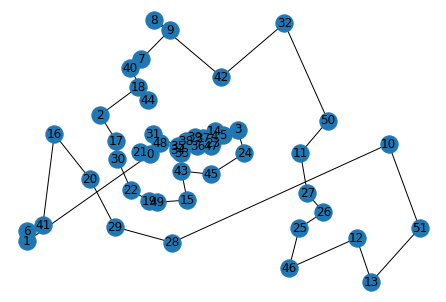

In [21]:
plotGraph(G)

In [22]:
print(total_distance(G))

8980.91827932919


### DEAP EVOLUTIONARY ALGORITHMS

In [23]:
toolbox = base.Toolbox()
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [24]:
toolbox.register("indices", np.random.permutation, len(tsp['CITIES']))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

In [25]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

In [26]:
def create_tour(individual):
    G = nx.Graph()
    G=nx.complete_graph(len(individual))
    G.clear_edges()
    for index,city in enumerate(tsp['CITIES']):
        G.nodes[index]['pos'] = (city.x,city.y)
        
    for index in range(len(individual)-1):
        G.add_edge(individual[index],individual[index+1])
    G.add_edge(individual[len(individual)-1],individual[0])
    
    return G

In [27]:
def evaluation(individual):
    return (total_distance(create_tour(individual)),)

In [28]:
toolbox.register("evaluate", evaluation)

In [29]:
toolbox.register("select", tools.selTournament, tournsize=3)

In [30]:
pop = toolbox.population(n=100)

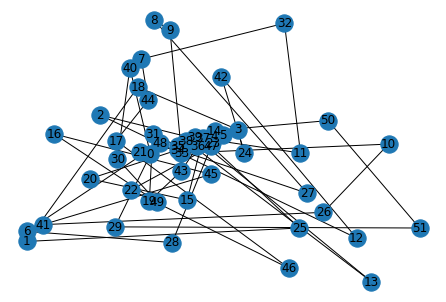

In [31]:
plotGraph(create_tour(pop[2]))

In [32]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)

In [33]:
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=400, verbose=False,stats=fit_stats)

In [34]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

Fitness of the best individual:  10680.64896164794


In [35]:
G = create_tour(best_individual)

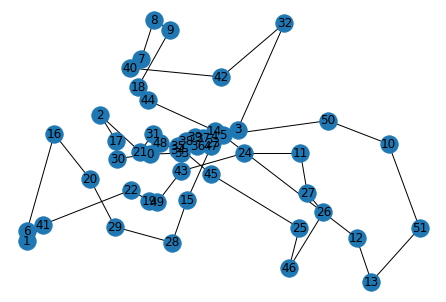

In [36]:
plotGraph(G)

Text(0.5, 1.0, 'berlin52 symetric graph')

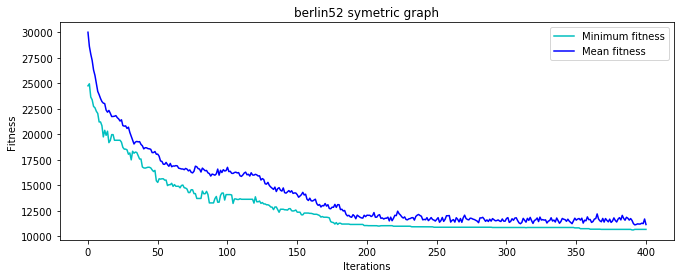

In [38]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');
plt.title("berlin52 symetric graph")